**Base case**


Mappings


In [85]:
# -------------------------------
# Trip Mapping
# -------------------------------
trip_mapping_inputs = {
    "Any trip mapping": [
        1020, 1012, 988, 980, 972, 1016, 964, 1008,
        1201, 984, 1199, 1196, 976, 1194, 968, 1192, 960,
        1190, 1202, 1188, 1200, 1232, 1197, 1230, 1195,
        1228, 1193, 1246, 1191, 1244, 1189, 1223, 1233,
        1221, 1231, 1219, 1229, 1217, 1247, 1051, 1245,
        1049, 1215, 1047, 1222, 1045, 1220, 956, 1218,
        954, 1216, 958, 1050, 953, 1048, 950, 1046, 1044,
        955, 959, 957, 951, 902
    ],
    "HV backup trip": [
        1016, 1219, 1218, 1217, 1216,
        1047, 1046, 1045, 1044,
        1008, 972, 968, 964, 960
    ],
    "LV backup trip": [
        1020, 1223, 1222, 1221, 1220,
        1051, 1050, 1049, 1048,
        1012, 988, 984, 980, 976
    ],
    "General alarm": [
        450, 475, 476, 478, 479, 480,
        481, 503, 508, 512, 504, 477
    ],
    "CB1 bktrip": [1529],
    "CB2 bktrip": [1531],
    "Any differential trip": [902, 950, 951, 953],
    "Fault Record Trigger": [1779, 891],
    "Any trip":[891]
}

# -------------------------------
# Dwell Times
# -------------------------------
dwell_time = {
    "Any trip mapping": 0,           # instantaneous
    "HV backup trip": 100,
    "LV backup trip": 100,
    "General alarm": 0,
    "CB1 bktrip": 100,
    "CB2 bktrip": 100,
    "Any differential trip": 100,
    "Fault Record Trigger": 100,
    "Any trip": 100
}

trip_mapping_outputs ={
    "Any trip mapping": [886],
    "HV backup trip": [324,0],
    "LV backup trip": [325,1],
    "General alarm": [3],
    "CB1 bktrip": [4],
    "CB2 bktrip": [5],
    "Any differential trip": [6],
    "Fault Record Trigger": [883],
    "Any trip":[2,7]

}

dropoff={
    "Any trip mapping":0,
    "HV backup trip":0,
    "LV backup trip":0,
    "General alarm":500,
    "CB1 bktrip":0,
    "CB2 bktrip":0,
    "Any differential trip":0,
    "Fault Record Trigger":0,
    "Any trip":0
}


Importing Libraries

In [86]:
!pip install torchviz
!pip install deepdiff
!pip install pytesseract pdfminer pdfminer.six pdfplumber


In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from torchviz import make_dot
import json
from deepdiff import DeepDiff
import pdfplumber
import pytesseract
import re
from PIL import Image, ImageOps


In [88]:
df = pd.read_csv("/content/ddb_states_1000cols_sparse.csv")  # shape: (N, D)
ddb_cols = df.columns[1:]  # skip "Row" if present

In [89]:
def get_enabled_trip(row, trip_mapping):
    for trip_name, ddbs in trip_mapping.items():
        if row[[str(ddb) for ddb in ddbs]].sum() > 0:
            return trip_name
    return "None"  # No trip enabled

df['label'] = df.apply(lambda row: get_enabled_trip(row, trip_mapping_inputs), axis=1)

In [90]:
df['ActiveTrips'] = df['label'].apply(lambda x: [x] if x != 'None' else [])


In [91]:
def compute_class_weights(df, trip_mapping_inputs, alpha=1.05):
    """
    Compute class weights based on inverse frequency and diminishing scaling.

    Args:
        df: DataFrame with columns 'label' and 'ActiveTrips'
        trip_mapping_inputs: dict containing trip names as keys
        alpha: diminishing factor (>1.0 reduces weight progressively)

    Returns:
        torch.Tensor of normalized class weights
    """
    trip_names = list(trip_mapping_inputs.keys())
    counts = torch.zeros(len(trip_names))

    # Count frequency of each trip occurrence
    for _, row in df.iterrows():
        if row['label'] == "None":
            continue
        active = row['ActiveTrips']
        for t in active:
            if t in trip_names:
                counts[trip_names.index(t)] += 1

    # Inverse frequency weighting
    weights = 1.0 / (counts + 1e-6)

    # Normalize inverse-frequency weights
    weights = weights / weights.sum() * len(trip_names)

    # Apply diminishing scaling factor — later classes have progressively smaller influence
    diminishing_factors = torch.tensor([1 / (alpha ** i) for i in range(len(trip_names))])
    weights = weights * diminishing_factors

    # Re-normalize to keep mean weight = 1
    weights = weights / weights.mean()

    return weights


In [92]:


# -----------------------------
# TripNet
# -----------------------------
class TripNet(nn.Module):
    def __init__(self, input_size, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


# -----------------------------
# Train one TripNet
# -----------------------------
def train_tripnet(trip_name, ddb_list, df, epochs=50, lr=0.01):
    X = df[[str(ddb) for ddb in ddb_list]].apply(pd.to_numeric, errors='coerce').fillna(0).values
    y = (X.sum(axis=1) > 0).astype(int)  # 1 if any active DDB, else 0

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    model = TripNet(X.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    print(f"{trip_name} trained, final loss = {loss.item():.4f}")
    return model


# -----------------------------
# Train all TripNets
# -----------------------------
trip_nets = {}
for trip_name, ddbs in trip_mapping_inputs.items():
    trip_nets[trip_name] = train_tripnet(trip_name, ddbs, df)


# -----------------------------
# TowerNet (combines all TripNets)
# -----------------------------
class TowerNet(nn.Module):
    def __init__(self, trip_nets, hidden=64):
        super().__init__()
        self.trip_nets = nn.ModuleDict(trip_nets)

        # Freeze TripNet weights
        for net in self.trip_nets.values():
            for p in net.parameters():
                p.requires_grad = False

        combined_size = len(trip_nets)
        self.fc = nn.Sequential(
            nn.Linear(combined_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(),
            nn.Linear(hidden // 2, combined_size)  # Multi-label outputs
        )

    def forward(self, inputs):
        trip_outputs = []
        for name, net in self.trip_nets.items():
            trip_out = net(inputs[name])
            if trip_out.ndim == 1:
                trip_out = trip_out.unsqueeze(1)
            trip_outputs.append(trip_out)
        combined = torch.cat(trip_outputs, dim=1)
        # combined = combined.clone().detach().requires_grad_(True)
        return self.fc(combined)  # logits


# -----------------------------
# Train TowerNet
# -----------------------------
def train_towernet(model, df, trip_mapping_inputs, epochs=25, lr=0.001):
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    trip_names = list(trip_mapping_inputs.keys())

    for epoch in range(epochs):
        total_loss = 0.0

        for _, row in df.iterrows():
            # Skip invalid rows
            if row['label'] == "None":
                continue

            # Prepare trip-wise inputs
            trip_inputs = {}
            for trip_name, ddbs in trip_mapping_inputs.items():
                x = row[[str(ddb) for ddb in ddbs]].apply(pd.to_numeric, errors='coerce').fillna(0).values
                trip_inputs[trip_name] = torch.tensor(x, dtype=torch.float32).unsqueeze(0)

            # Create multi-hot label (since multiple trips may be active)
            y_true = torch.zeros(len(trip_names))
            active_trips = row['ActiveTrips']  # list of active trip names
            for t in active_trips:
                if t in trip_names:
                    y_true[trip_names.index(t)] = 1.0

            optimizer.zero_grad()
            logits = model(trip_inputs)
            loss = criterion(logits, y_true.unsqueeze(0))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}  Loss: {total_loss/len(df):.4f}")

    torch.save(model.state_dict(), "tower_net.pth")
    model.load_state_dict(torch.load("tower_net.pth"))
    model.eval()


# -----------------------------
# Test TowerNet
# -----------------------------
def test_towernet(model, df, trip_mapping_inputs, threshold=0.5):
    trip_names = list(trip_mapping_inputs.keys())
    total, correct = 0, 0

    for _, row in df.iterrows():
        trip_inputs = {}
        for trip_name, ddbs in trip_mapping_inputs.items():
            x = row[[str(ddb) for ddb in ddbs]].apply(pd.to_numeric, errors='coerce').fillna(0).values
            trip_inputs[trip_name] = torch.tensor(x, dtype=torch.float32).unsqueeze(0)

        with torch.no_grad():
            logits = model(trip_inputs)
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).int().squeeze(0)

        # Ground truth
        y_true = torch.zeros(len(trip_names))
        active_trips = row['ActiveTrips']
        for t in active_trips:
            if t in trip_names:
                y_true[trip_names.index(t)] = 1

        if torch.equal(preds, y_true.int()):
            correct += 1
        total += 1

    print(f"TowerNet Multi-label Accuracy: {correct}/{total} = {correct/total:.2f}")




Any trip mapping trained, final loss = 0.0377
HV backup trip trained, final loss = 0.0008
LV backup trip trained, final loss = 0.0006
General alarm trained, final loss = 0.0004
CB1 bktrip trained, final loss = 0.0007
CB2 bktrip trained, final loss = 0.0007
Any differential trip trained, final loss = 0.0028
Fault Record Trigger trained, final loss = 0.0027
Any trip trained, final loss = 0.0010


In [93]:

# -----------------------------
# TripNet
# -----------------------------
class TripNet(nn.Module):
    def __init__(self, input_size, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# -----------------------------
# TowerNet
# -----------------------------
class TowerNet(nn.Module):
    def __init__(self, trip_nets, hidden=64):
        super().__init__()
        # Ensure trip_nets is initialized with the correct ModuleDict
        self.trip_nets = nn.ModuleDict({name: net for name, net in trip_nets.items()})


        # Freeze TripNet weights
        for net in self.trip_nets.values():
            for p in net.parameters():
                p.requires_grad = False

        combined_size = len(trip_nets)
        self.fc = nn.Sequential(
            nn.Linear(combined_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(),
            nn.Linear(hidden // 2, combined_size)  # Multi-label outputs
        )

    def forward(self, inputs):
        trip_outputs = []
        # Use the keys from self.trip_nets to ensure consistency
        for name in self.trip_nets.keys():
            # Ensure the input key matches the ModuleDict key
            trip_out = self.trip_nets[name](inputs[name])
            if trip_out.ndim == 1:
                trip_out = trip_out.unsqueeze(1)
            trip_outputs.append(trip_out)
        combined = torch.cat(trip_outputs, dim=1)
        return self.fc(combined)  # logits

# -----------------------------
# Utility functions
# -----------------------------
def make_trip_inputs(df_batch, trip_mapping_inputs):
    batch_inputs = {}
    for trip_name, ddbs in trip_mapping_inputs.items():
        x = df_batch[[str(ddb) for ddb in ddbs]].apply(pd.to_numeric, errors='coerce').fillna(0).values
        batch_inputs[trip_name] = torch.tensor(x, dtype=torch.float32)
    return batch_inputs

def make_multilabel(df_batch, trip_names):
    """
    Corrected: uses row index from enumerate to avoid IndexError
    """
    y = torch.zeros((len(df_batch), len(trip_names)))
    for row_idx, (_, row) in enumerate(df_batch.iterrows()):
        active_trips = row['ActiveTrips']
        for t in active_trips:
            if t in trip_names:
                y[row_idx, trip_names.index(t)] = 1
    return y

# -----------------------------
# Train one TripNet
# -----------------------------
def train_tripnet(trip_name, ddb_list, df, epochs=50, lr=0.01):
    X = df[[str(ddb) for ddb in ddb_list]].apply(pd.to_numeric, errors='coerce').fillna(0).values
    y = (X.sum(axis=1) > 0).astype(int)  # 1 if any active DDB, else 0

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    model = TripNet(X.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

    print(f"{trip_name} trained, final loss = {loss.item():.4f}")
    return model

# -----------------------------
# Train TowerNet with Early Stopping
# -----------------------------
def train_towernet(model, df_train, trip_mapping_inputs, epochs=100, lr=0.001,
                   batch_size=16, patience=10, min_delta=1e-4):
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    trip_names = list(trip_mapping_inputs.keys())

    best_loss = float('inf')
    wait = 0

    for epoch in range(epochs):
        total_loss = 0.0
        df_train = df_train.sample(frac=1).reset_index(drop=True)  # shuffle

        for i in range(0, len(df_train), batch_size):
            batch = df_train.iloc[i:i+batch_size]
            inputs = make_trip_inputs(batch, trip_mapping_inputs)
            y_true = make_multilabel(batch, trip_names)

            optimizer.zero_grad()
            logits = model(inputs)
            loss = criterion(logits, y_true)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(batch)

        avg_loss = total_loss / len(df_train)
        print(f"Epoch {epoch+1}/{epochs}  Loss: {avg_loss:.6f}")

        # Early stopping
        if best_loss - avg_loss > min_delta:
            best_loss = avg_loss
            wait = 0
            torch.save(model.state_dict(), "tower_net_best.pth")
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(torch.load("tower_net_best.pth"))
    model.eval()

# -----------------------------
# Test TowerNet & get predictions
# -----------------------------
def test_towernet(model, df_test, trip_mapping_inputs, threshold=0.5):
    trip_names = list(trip_mapping_inputs.keys())
    y_true_all, y_pred_all = [], []

    for i in range(len(df_test)):
        row = df_test.iloc[[i]]
        inputs = make_trip_inputs(row, trip_mapping_inputs)
        with torch.no_grad():
            logits = model(inputs)
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).int().squeeze(0)

        y_true = torch.zeros(len(trip_names))
        active_trips = row.iloc[0]['ActiveTrips']
        for t in active_trips:
            if t in trip_names:
                y_true[trip_names.index(t)] = 1

        y_true_all.append(y_true.numpy())
        y_pred_all.append(preds.numpy())

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    # Metrics
    f1 = f1_score(y_true_all, y_pred_all, average='samples')
    precision = precision_score(y_true_all, y_pred_all, average='samples')
    recall = recall_score(y_true_all, y_pred_all, average='samples')
    print(f"F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    # Predicted trips per row
    predicted_labels = []
    for row_preds in y_pred_all:
        labels = [trip_names[i] for i, p in enumerate(row_preds) if p==1]
        predicted_labels.append(labels)

    return predicted_labels

# -----------------------------
# -----------------------------
# Example Usage
# -----------------------------
# Assume `df` is your dataframe with DDB columns as strings and 'ActiveTrips' as a list column

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Train TripNets
trip_nets = {}
for trip_name, ddbs in trip_mapping_inputs.items():
    trip_nets[trip_name] = train_tripnet(trip_name, ddbs, train_df, epochs=50, lr=0.01)

# Initialize TowerNet
tower_model = TowerNet(trip_nets)

# Train TowerNet with Early Stopping
train_towernet(tower_model, train_df, trip_mapping_inputs, epochs=100, lr=0.001,
               batch_size=16, patience=10, min_delta=1e-4)

Any trip mapping trained, final loss = 0.0025
HV backup trip trained, final loss = 0.0005
LV backup trip trained, final loss = 0.0008
General alarm trained, final loss = 0.0004
CB1 bktrip trained, final loss = 0.0229
CB2 bktrip trained, final loss = 0.0005
Any differential trip trained, final loss = 0.0034
Fault Record Trigger trained, final loss = 0.0046
Any trip trained, final loss = 0.0012
Epoch 1/100  Loss: 0.593251
Epoch 2/100  Loss: 0.235701
Epoch 3/100  Loss: 0.101408
Epoch 4/100  Loss: 0.068201
Epoch 5/100  Loss: 0.045083
Epoch 6/100  Loss: 0.031339
Epoch 7/100  Loss: 0.022769
Epoch 8/100  Loss: 0.016960
Epoch 9/100  Loss: 0.013492
Epoch 10/100  Loss: 0.011430
Epoch 11/100  Loss: 0.010135
Epoch 12/100  Loss: 0.009108
Epoch 13/100  Loss: 0.008296
Epoch 14/100  Loss: 0.007636
Epoch 15/100  Loss: 0.007020
Epoch 16/100  Loss: 0.006452
Epoch 17/100  Loss: 0.005985
Epoch 18/100  Loss: 0.005552
Epoch 19/100  Loss: 0.005171
Epoch 20/100  Loss: 0.004841
Epoch 21/100  Loss: 0.004575
Epoc

In [94]:
predicted_labels = test_towernet(tower_model, test_df, trip_mapping_inputs, threshold=0.5)

F1: 0.7250, Precision: 0.7250, Recall: 0.7250


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [95]:


def get_enabled_trips_from_values(values, ddb_columns, trip_mapping_inputs):
    """Return actual enabled trips for given raw DDB values."""
    row = pd.Series({str(col): val for col, val in zip(ddb_columns, values)})
    enabled = []
    for trip_name, ddbs in trip_mapping_inputs.items():
        if row[[str(ddb) for ddb in ddbs]].sum() > 0:
            enabled.append(trip_name)
    return enabled


def predict_custom_input(model, trip_mapping_inputs, custom_ddb_values, ddb_columns, threshold=0.5):
    """
    Predict multi-label trip outputs for a given custom DDB input,
    and display merged Predicted vs Actual results.
    """
    print("\n🔹 Running prediction for custom input...")

    # Convert custom input to Series
    custom_row = pd.Series({str(col): val for col, val in zip(ddb_columns, custom_ddb_values)})

    # Compute actual enabled trips (based on input DDBs)
    actual_trips = get_enabled_trips_from_values(custom_ddb_values, ddb_columns, trip_mapping_inputs)

    # Prepare input tensors for model
    trip_inputs = {}
    for trip_name, ddbs in trip_mapping_inputs.items():
        x = custom_row[[str(ddb) for ddb in ddbs]].values
        x = pd.to_numeric(x, errors='coerce').astype(float)
        trip_inputs[trip_name] = torch.tensor(x, dtype=torch.float32).unsqueeze(0)

    # Model prediction
    with torch.no_grad():
        out = model(trip_inputs)
        probs = torch.sigmoid(out).squeeze()
        predicted_trips = [list(trip_mapping_inputs.keys())[i]
                           for i, p in enumerate(probs) if p > threshold]

    # Combine and display
    print("\n📊 Trip-wise Prediction Probabilities:")
    for trip_name, prob in zip(trip_mapping_inputs.keys(), probs.tolist()):
        print(f" - {trip_name}: {prob:.4f}")

    # Merge Predicted vs Actual
    all_trip_names = sorted(set(predicted_trips + actual_trips))
    results_df = pd.DataFrame({
        "Trip Name": all_trip_names,
        "Predicted": ["✅" if t in predicted_trips else "❌" for t in all_trip_names],
        "Actual":    ["✅" if t in actual_trips else "❌" for t in all_trip_names],
    })

    print("\n🔍 Combined Predicted vs Actual Comparison:")
    print(results_df.to_string(index=False))

    # Return structured result for logging
    return {
        "probabilities": {trip: prob for trip, prob in zip(trip_mapping_inputs.keys(), probs.tolist())},
        "predicted": predicted_trips,
        "actual": actual_trips,
        "comparison": results_df
    }

def predict_multiple(model, trip_mapping_inputs, input_list, ddb_columns, threshold=0.5):
    all_results = []

    for idx, custom_ddb_values in enumerate(input_list):
        print(f"\n🔹 Input Sample {idx+1}")

        # Build row
        custom_row = pd.Series({str(col): val for col, val in zip(ddb_columns, custom_ddb_values)})

        # Actual trips (ground truth)
        actual_trips = get_enabled_trips_from_values(custom_ddb_values, ddb_columns, trip_mapping_inputs)

        # ----- NEW: Direct TripNet pass (pre-TowerNet) -----
        trip_outputs = {}
        for trip_name, ddbs in trip_mapping_inputs.items():
            x = custom_row[[str(ddb) for ddb in ddbs]].values
            x = pd.to_numeric(x, errors='coerce').astype(float)
            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                trip_outputs[trip_name] = model.trip_nets[trip_name](x_tensor).item()

        # Predict based on trip outputs (this mimics TowerNet)
        combined_input = torch.tensor(list(trip_outputs.values()), dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            logits = model.fc(combined_input)
            probs = torch.sigmoid(logits).squeeze()

        # Combine predictions (TripNet + TowerNet)
        final_probs = {trip: max(trip_outputs[trip], probs[i].item())
                       for i, trip in enumerate(trip_mapping_inputs.keys())}
        predicted_trips = [t for t, p in final_probs.items() if p > threshold]

        # Print results
        print("\n📊 Trip-wise Prediction Probabilities:")
        for t, p in final_probs.items():
            print(f" - {t}: {p:.4f}")

        # Build comparison
        comparison_df = pd.DataFrame({
            "Trip Name": list(final_probs.keys()),
            "Predicted": ["✅" if t in predicted_trips else "❌" for t in final_probs.keys()],
            "Actual": ["✅" if t in actual_trips else "❌" for t in final_probs.keys()]
        })

        print("\n🔍 Combined Predicted vs Actual Comparison:")
        print(comparison_df[comparison_df["Actual"] == "✅"])

        all_results.append({
            "probabilities": final_probs,
            "predicted": predicted_trips,
            "actual": actual_trips,
            "comparison": comparison_df
        })

    return all_results


In [96]:
# Example input vector (same as you gave)
custom_ddb_values = [
    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
]

ddb_columns = [
    450, 475, 476, 477, 478, 479, 480, 481, 503, 504, 508, 512, 891, 902,
    950, 951, 953, 954, 955, 956, 957, 958, 959, 960, 964, 968, 972, 976,
    980, 984, 988, 1008, 1012, 1016, 1020, 1044, 1045, 1046, 1047, 1048, 1049,
    1050, 1051, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197,
    1199, 1200, 1201, 1202, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222,
    1223, 1228, 1229, 1230, 1231, 1232, 1233, 1244, 1245, 1246, 1247, 1529,
    1531, 1779
]
# Convert list input to dictionary
# -------------------------------
custom_ddb_dict = {ddb: val for ddb, val in zip(ddb_columns, custom_ddb_values)}


In [97]:
custom_ddb_dict

{450: 0,
 475: 0,
 476: 0,
 477: 0,
 478: 0,
 479: 0,
 480: 0,
 481: 0,
 503: 0,
 504: 0,
 508: 0,
 512: 0,
 891: 0,
 902: 0,
 950: 0,
 951: 0,
 953: 0,
 954: 0,
 955: 0,
 956: 0,
 957: 0,
 958: 0,
 959: 0,
 960: 0,
 964: 0,
 968: 0,
 972: 0,
 976: 0,
 980: 0,
 984: 0,
 988: 0,
 1008: 0,
 1012: 0,
 1016: 0,
 1020: 0,
 1044: 0,
 1045: 0,
 1046: 0,
 1047: 0,
 1048: 0,
 1049: 0,
 1050: 0,
 1051: 0,
 1188: 0,
 1189: 0,
 1190: 0,
 1191: 0,
 1192: 0,
 1193: 0,
 1194: 0,
 1195: 0,
 1196: 0,
 1197: 0,
 1199: 0,
 1200: 0,
 1201: 0,
 1202: 0,
 1215: 0,
 1216: 0,
 1217: 0,
 1218: 0,
 1219: 0,
 1220: 0,
 1221: 0,
 1222: 0,
 1223: 0,
 1228: 0,
 1229: 0,
 1230: 0,
 1231: 0,
 1232: 0,
 1233: 0,
 1244: 0,
 1245: 0,
 1246: 0,
 1247: 0,
 1529: 0,
 1531: 0,
 1779: 1}

In [98]:
input_list = [custom_ddb_values]


In [99]:
predicted_trips=predict_multiple(tower_model,trip_mapping_inputs,input_list,ddb_columns)


🔹 Input Sample 1

📊 Trip-wise Prediction Probabilities:
 - Any trip mapping: 0.0051
 - HV backup trip: 0.0003
 - LV backup trip: 0.0006
 - General alarm: 0.0002
 - CB1 bktrip: 0.0047
 - CB2 bktrip: 0.0023
 - Any differential trip: 0.0025
 - Fault Record Trigger: 0.9924
 - Any trip: 0.0009

🔍 Combined Predicted vs Actual Comparison:
              Trip Name Predicted Actual
7  Fault Record Trigger         ✅      ✅


In [100]:
print(predicted_trips)

[{'probabilities': {'Any trip mapping': 0.005139391403645277, 'HV backup trip': 0.00031259257229976356, 'LV backup trip': 0.0005719065084122121, 'General alarm': 0.0001762779284035787, 'CB1 bktrip': 0.004665306303650141, 'CB2 bktrip': 0.0022741886787116528, 'Any differential trip': 0.0024715131148695946, 'Fault Record Trigger': 0.9923655390739441, 'Any trip': 0.0008622692548669875}, 'predicted': ['Fault Record Trigger'], 'actual': ['Fault Record Trigger'], 'comparison':                Trip Name Predicted Actual
0       Any trip mapping         ❌      ❌
1         HV backup trip         ❌      ❌
2         LV backup trip         ❌      ❌
3          General alarm         ❌      ❌
4             CB1 bktrip         ❌      ❌
5             CB2 bktrip         ❌      ❌
6  Any differential trip         ❌      ❌
7   Fault Record Trigger         ✅      ✅
8               Any trip         ❌      ❌}]


In [101]:
# Convert single-step actual to binary dict
actual_trips_list = predicted_trips[0]['actual']  # e.g., ['Fault Record Trigger']
actual_trips_dict = {block: int(block in actual_trips_list) for block in trip_mapping_inputs}


In [102]:
trip_names = list(trip_mapping_inputs.keys())
predicted_trips_dict = {
    name: int(name in predicted_trips[0]['predicted'])
    for name in trip_names
}


In [103]:
# Initialize dwell counter and block state
dwell_counter = {block: 0 for block in trip_mapping_inputs}
block_state = {block: 0 for block in trip_mapping_inputs}
dropoff_counter= {block: 0 for block in trip_mapping_inputs}

In [104]:

# -------------------------------
# Functions
# -------------------------------

def compute_block_logic(ddb_states, category):
    """Compute OR logic of DDBs for a given block"""
    ddbs = trip_mapping_inputs[category]
    logic_output = int(any(ddb_states.get(ddb, 0) for ddb in ddbs))
    return logic_output

# def update_blocks(ddb_states):
#     """Apply dwell logic and latching"""
#     global block_state, dwell_counter
#     for category in trip_mapping_inputs.keys():
#         logic_output = compute_block_logic(ddb_states, category)

#         # Apply dwell
#         if logic_output:
#             dwell_counter[category] += 1
#         else:
#             dwell_counter[category] = 0

#         # Latch if dwell threshold reached
#         if dwell_counter[category] >= dwell_time[category]:
#             block_state[category] = 1
#     return block_state

def update_blocks(ddb_states):
    """Apply dwell logic, latching, and drop-off"""
    global block_state, dwell_counter, dropoff_counter

    for category in trip_mapping_inputs.keys():
        logic_output = compute_block_logic(ddb_states, category)

        # --- Dwell Logic (turn ON) ---
        if logic_output:
            dwell_counter[category] += 1
        else:
            dwell_counter[category] = 0

        # Latch if dwell threshold reached
        if dwell_counter[category] >= dwell_time[category]:
            block_state[category] = 1

        # --- Drop-off Logic (turn OFF) ---
        if not logic_output and block_state[category] == 1:
            # Initialize drop-off counter if not present
            dropoff_counter[category] = dropoff_counter.get(category, 0) + 1
            # Reset block if drop-off threshold reached
            if dropoff_counter[category] >= dropoff[category]:
                block_state[category] = 0
                dropoff_counter[category] = 0
        else:
            dropoff_counter[category] = 0  # reset if logic_output is high

    return block_state


In [105]:
# timesteps = range(10)
# actual_curve = {block: [actual_trips_dict[block]]*len(timesteps) for block in trip_mapping_inputs}
# predicted_curve = {block: [predicted_trips_dict[block]]*len(timesteps) for block in trip_mapping_inputs}
# for t in timesteps:
#     actual_block_outputs = update_blocks(custom_ddb_dict)
#     for block in trip_mapping_inputs:
#         actual_curve[block].append(actual_block_outputs[block])
#         predicted_curve[block].append(predicted_trips_dict[block])  # same predicted values

# # -------------------------------
# # Plot Actual vs Predicted
# # -------------------------------
# num_blocks = len(trip_mapping_inputs)
# plt.figure(figsize=(12, 2*num_blocks))

# for i, block in enumerate(trip_mapping_inputs.keys()):
#     plt.subplot(num_blocks, 1, i+1)
#     plt.step(timesteps, actual_curve[block], where='post', label='Actual', linewidth=2)
#     plt.step(timesteps, predicted_curve[block], where='post', label='Predicted', linestyle='--')
#     plt.ylim(-0.2, 1.2)
#     plt.ylabel(block)
#     plt.grid(True)
#     if i == num_blocks - 1:
#         plt.xlabel("Timesteps")
#     plt.legend(loc='upper right')

# plt.suptitle("Trip Logic Comparison: Actual vs Predicted", fontsize=16)
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()
# # file_path = "/content/ddb_states_1000cols_sparse.csv"
# # # timestep = 0

# # ddb_dataset = read_ddb_states_transposed(file_path, timestep)
# # current_block_outputs = update_blocks(ddb_dataset)

# # print("Block Outputs at timestep", timestep)
# # for block, state in current_block_outputs.items():
# #     print(f"{block}: {state}")


# # # -------------------------------
# # # Plot outputs
# # # -------------------------------
# # num_blocks = len(current_block_outputs)
# # plt.figure(figsize=(12, 2*num_blocks))

# # for i, (block, value) in enumerate(current_block_outputs.items()):
# #     plt.subplot(num_blocks, 1, i+1)
# #     plt.step([0, 1], [value, value], where='post')
# #     plt.ylim(-0.2, 1.2)
# #     plt.ylabel(block)
# #     plt.grid(True)
# #     if i == num_blocks - 1:
# #         plt.xlabel(f"Timestep {timestep}")

# # plt.suptitle(f"Protection Block Outputs at Timestep {timestep}", fontsize=16)
# # plt.tight_layout(rect=[0, 0, 1, 0.96])
# # plt.show()

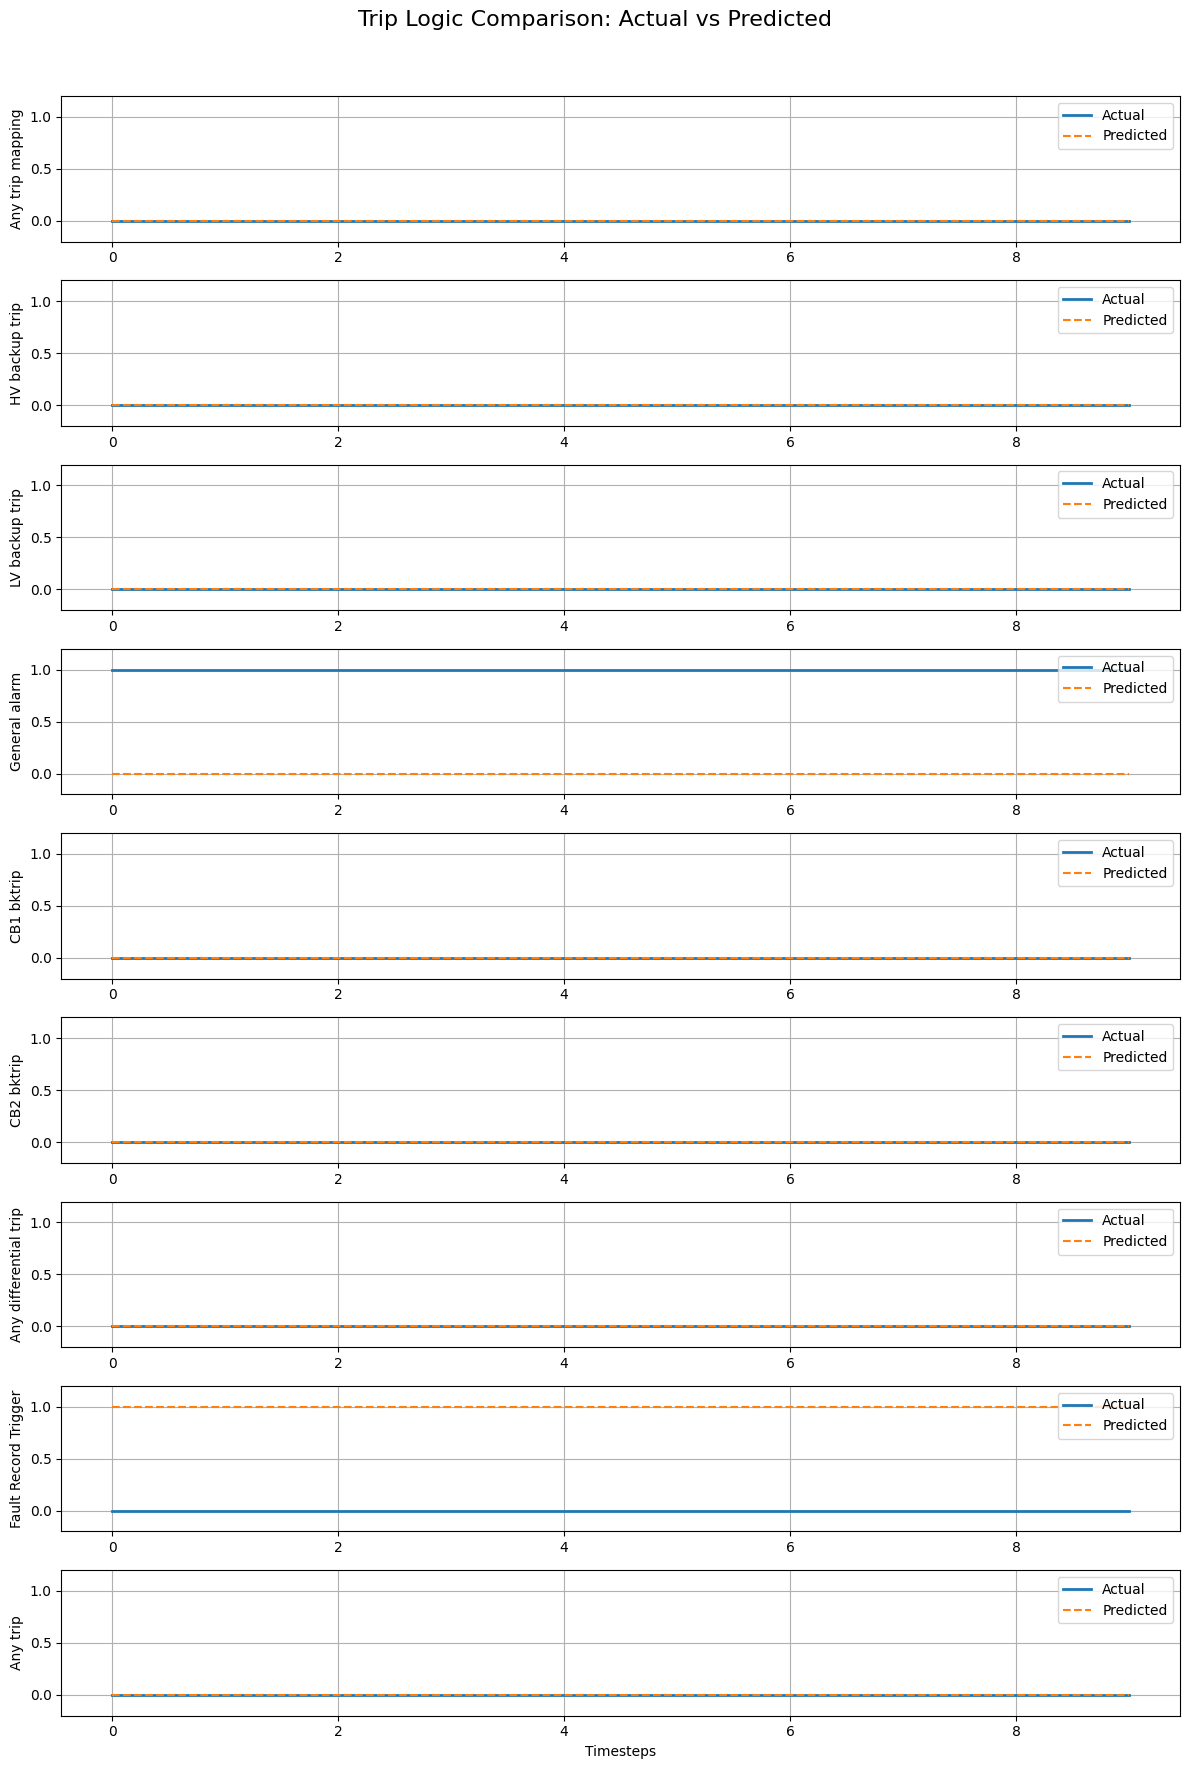

In [106]:
timesteps = range(10)
actual_curve = {block: [] for block in trip_mapping_inputs}
predicted_curve = {block: [predicted_trips_dict[block]]*len(timesteps) for block in trip_mapping_inputs}

for t in timesteps:
    actual_block_outputs = update_blocks(custom_ddb_dict)
    for block in trip_mapping_inputs:
        actual_curve[block].append(actual_block_outputs[block])

# -------------------------------
# Plot Actual vs Predicted
# -------------------------------
num_blocks = len(trip_mapping_inputs)
plt.figure(figsize=(12, 2*num_blocks))

for i, block in enumerate(trip_mapping_inputs.keys()):
    plt.subplot(num_blocks, 1, i+1)
    plt.step(timesteps, actual_curve[block], where='post', label='Actual', linewidth=2)
    plt.step(timesteps, predicted_curve[block], where='post', label='Predicted', linestyle='--')
    plt.ylim(-0.2, 1.2)
    plt.ylabel(block)
    plt.grid(True)
    if i == num_blocks - 1:
        plt.xlabel("Timesteps")
    plt.legend(loc='upper right')

plt.suptitle("Trip Logic Comparison: Actual vs Predicted", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [107]:
# Create a new instance of TowerNet with the correct trip_nets structure
# Use the trip_mapping_inputs to define the structure
trip_nets_for_loading = {}
for trip_name, ddbs in trip_mapping_inputs.items():
    # Need the correct input size for each TripNet based on the current trip_mapping_inputs
    input_size = len(ddbs)
    trip_nets_for_loading[trip_name] = TripNet(input_size)

tower_net = TowerNet(trip_nets_for_loading)

# Load the state dictionary
tower_net.load_state_dict(torch.load("tower_net_best.pth"))
tower_net.eval()

TowerNet(
  (trip_nets): ModuleDict(
    (Any trip mapping): TripNet(
      (net): Sequential(
        (0): Linear(in_features=63, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): Linear(in_features=32, out_features=1, bias=True)
        (5): Sigmoid()
      )
    )
    (HV backup trip): TripNet(
      (net): Sequential(
        (0): Linear(in_features=14, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): Linear(in_features=32, out_features=1, bias=True)
        (5): Sigmoid()
      )
    )
    (LV backup trip): TripNet(
      (net): Sequential(
        (0): Linear(in_features=14, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): Linear(in_features=32, out_features=1, bias=True)
        (5): Sigmoid()
   

In [108]:
# Create trip_nets dict
trip_nets = {
    'Any Trip Mapping': TripNet(63),
    'HV Backup': TripNet(14),
    'LV Backup': TripNet(14),
    'General Alarm': TripNet(12),
    'CB1 Backup Trip': TripNet(1),
    'CB2 Backup Trip': TripNet(1),
    'Any Differential Trip': TripNet(4),
    'Fault Record Trigger': TripNet(2),
    'Any Trip': TripNet(1),
}

# Initialize TowerNet
tower_net = TowerNet(trip_nets)

# Create dummy inputs for each TripNet
dummy_inputs = {
    'Any Trip Mapping': torch.randn(1, 63),
    'HV Backup': torch.randn(1, 14),
    'LV Backup': torch.randn(1, 14),
    'General Alarm': torch.randn(1, 12),
    'CB1 Backup Trip': torch.randn(1, 1),
    'CB2 Backup Trip': torch.randn(1, 1),
    'Any Differential Trip': torch.randn(1, 4),
    'Fault Record Trigger': torch.randn(1, 2),
    'Any Trip': torch.randn(1, 1),
}

# Forward pass
output = tower_net(dummy_inputs)

# Visualize with torchviz
dot = make_dot(output, params=dict(tower_net.named_parameters()))
dot.format = 'png'
dot.render('tower_net_graph', view=True)  # saves and opens tower_net_graph.png

'tower_net_graph.png'

validation of psl

In [109]:
# -------- Comparison Function --------
def print_diff(label, old, new):
    print(f"\n🔍 Changes in {label}:")
    diff = DeepDiff(old, new, ignore_order=True).to_dict()
    if not diff:
        print("✅ No changes.")
        return

    for change_type, changes in diff.items():
        print(f"\n{change_type}:")
        print(json.dumps(changes, indent=4))


In [110]:
new_trip_mapping_inputs={
    "Any trip mapping": [
        1020, 1012, 988, 980, 972, 1016, 964, 1008,
        1201, 984, 1199, 1196, 976, 1194, 968, 1192, 960,
        1190, 1202, 1188, 1200, 1232, 1197, 1230, 1195,
        1228, 1193, 1246, 1191, 1244, 1189, 1223, 1233,
        1221, 1231, 1219, 1229, 1217, 1247, 1051, 1245,
        1049, 1215, 1047, 1222, 1045, 1220, 956, 1218,
        954, 1216, 958, 1050, 953, 1048, 950, 1046, 1044,
        955, 959, 957, 951,902
    ],
    "HV backup trip": [
        1016, 1219, 1218, 1217, 1216,
        1047, 1046, 1045, 1044,
        1008, 972, 968, 964, 960
    ],
    "LV backup trip": [
        1020, 1223, 1222, 1221, 1220,
        1051, 1050, 1049, 1048,
        1012, 984, 980, 976
    ],
    "General alarm": [
        450, 475, 476, 478, 479, 480,
        481, 503, 508, 512, 504, 477
    ],
    "CB1 bktrip": [1529],
    "CB2 bktrip": [1531],
    "Any differential trip": [902, 950, 951, 953],
    "Fault Record Trigger": [1779, 891],
    "Any trip":[891]
}

# -------------------------------
# Dwell Times
# -------------------------------
new_dwell_time = {
    "Any trip mapping": 0,           # instantaneous
    "HV backup trip": 100,
    "LV backup trip": 300,
    "General alarm": 0,
    "CB1 bktrip": 100,
    "CB2 bktrip": 100,
    "Any differential trip": 100,
    "Fault Record Trigger": 100,
    "Any trip": 100
}

new_trip_mapping_outputs ={
    "Any trip mapping": [886],
    "HV backup trip": [324,0],
    "LV backup trip": [325,1],
    "General alarm": [3],
    "CB1 bktrip": [4],
    "CB2 bktrip": [5],
    "Any differential trip": [6],
    "Fault Record Trigger": [883],
    "Any trip":[2,7]

}

new_dropoff={
    "Any trip mapping":0,
    "HV backup trip":0,
    "LV backup trip":0,
    "General alarm":100,
    "CB1 bktrip":0,
    "CB2 bktrip":0,
    "Any differential trip":0,
    "Fault Record Trigger":0,
    "Any trip":0
}


In [111]:
print_diff("trip_mapping_inputs", new_trip_mapping_inputs, trip_mapping_inputs)
print_diff("dwell_time", new_dwell_time, dwell_time)
print_diff("trip_mapping_outputs", new_trip_mapping_outputs, trip_mapping_outputs)
print_diff("dropoff", new_dropoff, dropoff)


🔍 Changes in trip_mapping_inputs:

iterable_item_added:
{
    "root['LV backup trip'][10]": 988
}

🔍 Changes in dwell_time:

values_changed:
{
    "root['LV backup trip']": {
        "new_value": 100,
        "old_value": 300
    }
}

🔍 Changes in trip_mapping_outputs:
✅ No changes.

🔍 Changes in dropoff:

values_changed:
{
    "root['General alarm']": {
        "new_value": 500,
        "old_value": 100
    }
}


In [112]:
def predict_custom(model, trip_mapping_inputs, ddb_values, ddb_columns, threshold=0.5):
    """
    Predict active trips using previously trained TowerNet weights
    with updated trip_mapping_inputs. No dwell/latch/dropoff applied.
    """
    row = pd.Series({str(col): val for col, val in zip(ddb_columns, ddb_values)})
    trip_inputs = {}

    for trip_name, ddbs in trip_mapping_inputs.items():
        x = row[[str(ddb) for ddb in ddbs if str(ddb) in row.index]].apply(pd.to_numeric, errors='coerce').fillna(0).values
        trip_inputs[trip_name] = torch.tensor(x, dtype=torch.float32).unsqueeze(0)

    with torch.no_grad():
        logits = model(trip_inputs)
        probs = torch.sigmoid(logits).squeeze(0)
        predicted_trips = [trip_name for i, trip_name in enumerate(trip_mapping_inputs.keys()) if probs[i] > threshold]

    return predicted_trips, probs.tolist()


Parsing inputs/outputs from psl file

In [113]:


# Trip topics
TRIP_TOPICS = [
    "Any trip mapping", "HV backup trip", "LV backup trip",
    "CB1 bktrip", "CB2 bktrip", "General alarm",
    "Any differential trip", "Fault Record Trigger", "Any trip"
]

# Output DDBs (to exclude)
trip_mapping_outputs = {
    "Any trip mapping": [886],
    "HV backup trip": [324, 0],
    "LV backup trip": [325, 1],
    "General alarm": [3],
    "CB1 bktrip": [4],
    "CB2 bktrip": [5],
    "Any differential trip": [6],
    "Fault Record Trigger": [883],
    "Any trip": [2, 7]
}

# Manually add missing DDBs (only once)
missing_ddbs = {
    "HV backup trip": [1045],
    "LV backup trip": [1049],
    "General alarm": [480]
}

def extract_trip_mappings(pdf_file):
    trip_blocks = []
    duplicates_dict = {}

    with pdfplumber.open(pdf_file) as pdf:
        for page_no, page in enumerate(pdf.pages, start=1):
            text = page.extract_text()

            if not text or text.strip() == "":
                im = page.to_image(resolution=300).original
                im = ImageOps.grayscale(im)
                text = pytesseract.image_to_string(im)

            lines = text.split("\n")
            current_trip = None
            current_inputs = set()
            seen_ddbs = []

            for line in lines:
                line = re.sub(r'\s+', ' ', line.strip())
                if not line:
                    continue

                # Detect trip label
                for trip in TRIP_TOPICS:
                    if trip in line:
                        if current_trip and current_inputs:
                            trip_blocks.append({
                                "Trip": current_trip,
                                "Inputs": ", ".join(sorted(current_inputs)),
                                "Page": page_no
                            })

                            dups = [x for x in seen_ddbs if seen_ddbs.count(x) > 1]
                            if dups:
                                duplicates_dict[current_trip] = sorted(set(dups))

                        current_trip = trip
                        current_inputs = set()
                        seen_ddbs = []
                        break

                # Extract DDBs
                ddb_matches = re.findall(r"D[DB0]{2}\s*#?\s*(\d+)", line)
                if ddb_matches and current_trip:
                    matching_key = next(
                        (k for k in trip_mapping_outputs.keys() if k.lower() == current_trip.lower()), None
                    )
                    outputs_to_exclude = set(trip_mapping_outputs.get(matching_key, [])) if matching_key else set()
                    filtered_ddbs = [num for num in ddb_matches if int(num) not in outputs_to_exclude]

                    # ✅ Add missing DDBs only if not already present
                    if current_trip in missing_ddbs:
                        for num in missing_ddbs[current_trip]:
                            if str(num) not in filtered_ddbs and str(num) not in seen_ddbs:
                                filtered_ddbs.append(str(num))

                    seen_ddbs.extend(filtered_ddbs)
                    current_inputs.update(f"DDB #{num}" for num in filtered_ddbs)

            # Append final block for last trip
            if current_trip and current_inputs:
                trip_blocks.append({
                    "Trip": current_trip,
                    "Inputs": ", ".join(sorted(current_inputs)),
                    "Page": page_no
                })

                dups = [x for x in seen_ddbs if seen_ddbs.count(x) > 1]
                if dups:
                    duplicates_dict[current_trip] = sorted(set(dups))

    return trip_blocks, duplicates_dict


# === Usage ===
pdf_file = "PSL_Transformer.pdf"
trips, duplicates = extract_trip_mappings(pdf_file)

# Save main data
df = pd.DataFrame(trips)
df.to_csv("psl_trip_mappings.csv", index=False)

# Save duplicates dictionary
duplicates_df = pd.DataFrame([
    {"Trip": trip, "Duplicate DDBs": ", ".join(ddbs)}
    for trip, ddbs in duplicates.items()
])
duplicates_df.to_csv("psl_trip_duplicates.csv", index=False)

print("✅ Main CSV written as psl_trip_mappings.csv")
print("✅ Duplicates CSV written as psl_trip_duplicates.csv")
print("\nDuplicates dictionary:\n", duplicates)


✅ Main CSV written as psl_trip_mappings.csv
✅ Duplicates CSV written as psl_trip_duplicates.csv

Duplicates dictionary:
 {}


In [114]:
# === Usage ===
pdf_file = "changeinpsl.pdf"
trips, duplicates = extract_trip_mappings(pdf_file)

# Save main data
df = pd.DataFrame(trips)
df.to_csv("psl_trip_mappings1.csv", index=False)

# Save duplicates dictionary
duplicates_df = pd.DataFrame([
    {"Trip": trip, "Duplicate DDBs": ", ".join(ddbs)}
    for trip, ddbs in duplicates.items()
])
duplicates_df.to_csv("psl_trip_duplicates1.csv", index=False)

print("✅ Main CSV written as psl_trip_mappings.csv")
print("✅ Duplicates CSV written as psl_trip_duplicates.csv")
print("\nDuplicates dictionary:\n", duplicates)


✅ Main CSV written as psl_trip_mappings.csv
✅ Duplicates CSV written as psl_trip_duplicates.csv

Duplicates dictionary:
 {'Any trip mapping': ['902']}


In [115]:
# === Merge duplicates into main mapping dictionary ===
trip_dict = {}

for _, row in df.iterrows():
    trip_name = row["Trip"]

    # Extract numeric DDBs from the "Inputs" string
    ddb_numbers = [int(num) for num in re.findall(r'\d+', row["Inputs"])]

    # If this trip has duplicates, add them again to preserve original count
    if trip_name in duplicates:
        for dup in duplicates[trip_name]:
            ddb_numbers.append(int(dup))

    # Store final list (including duplicates) in dictionary
    trip_dict[trip_name] = ddb_numbers

print("\n✅ Final merged dictionary (duplicates included):\n")
print(trip_dict)



✅ Final merged dictionary (duplicates included):

{'Any trip mapping': [1008, 1012, 1016, 1020, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1199, 1200, 1201, 1202, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1228, 1229, 1230, 1231, 1232, 1233, 1244, 1245, 1246, 1247, 902, 950, 953, 954, 955, 956, 957, 958, 959, 960, 964, 968, 972, 976, 980, 984, 988, 902], 'HV backup trip': [1008, 1016, 1044, 1045, 1046, 1047, 1216, 1217, 1218, 1219, 950, 964, 968, 972], 'LV backup trip': [1012, 1020, 1048, 1049, 1050, 1051, 1220, 1221, 1222, 1223, 976, 980, 984, 988], 'Any trip': [891], 'General alarm': [450, 475, 476, 477, 478, 479, 480, 481, 503, 504, 508, 512], 'CB1 bktrip': [1529], 'CB2 bktrip': [1531], 'Any differential trip': [902, 950, 951, 953], 'Fault Record Trigger': [1779, 891]}


In [116]:
trip_dict

{'Any trip mapping': [1008,
  1012,
  1016,
  1020,
  1044,
  1045,
  1046,
  1047,
  1048,
  1049,
  1050,
  1051,
  1188,
  1189,
  1190,
  1191,
  1192,
  1193,
  1194,
  1195,
  1196,
  1197,
  1199,
  1200,
  1201,
  1202,
  1215,
  1216,
  1217,
  1218,
  1219,
  1220,
  1221,
  1222,
  1223,
  1228,
  1229,
  1230,
  1231,
  1232,
  1233,
  1244,
  1245,
  1246,
  1247,
  902,
  950,
  953,
  954,
  955,
  956,
  957,
  958,
  959,
  960,
  964,
  968,
  972,
  976,
  980,
  984,
  988,
  902],
 'HV backup trip': [1008,
  1016,
  1044,
  1045,
  1046,
  1047,
  1216,
  1217,
  1218,
  1219,
  950,
  964,
  968,
  972],
 'LV backup trip': [1012,
  1020,
  1048,
  1049,
  1050,
  1051,
  1220,
  1221,
  1222,
  1223,
  976,
  980,
  984,
  988],
 'Any trip': [891],
 'General alarm': [450, 475, 476, 477, 478, 479, 480, 481, 503, 504, 508, 512],
 'CB1 bktrip': [1529],
 'CB2 bktrip': [1531],
 'Any differential trip': [902, 950, 951, 953],
 'Fault Record Trigger': [1779, 891]}

In [117]:


# -------- Comparison Function --------
def print_diff(label, old, new):
    print(f"\n🔍 Changes in {label}:")
    diff = DeepDiff(old, new, ignore_order=True).to_dict()
    if not diff:
        print("✅ No changes.")
        return {}  # return empty dict instead of None

    for change_type, changes in diff.items():
        print(f"\n{change_type}:")
        print(json.dumps(changes, indent=4))

    return diff  # ✅ return the actual diff for further use


In [118]:
# -----------------------------
# Update weights after trip_mapping changes with deactivated input handling
# -----------------------------
def update_tripnet_weights(model, trip_mapping_inputs, df, changes,
                           fine_tune_epochs=10, lr=1e-3):
    """
    Updates TripNet/TowerNet weights when trip_mapping changes occur.
    Supports:
    - Fine-tuning affected TripNets
    - Zeroing weights for deactivated/removed DDBs
    - Re-training TowerNet FC head
    """
    import re
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import pandas as pd

    if not changes or not isinstance(changes, dict):
        print("⚠️ No changes provided or invalid format — skipping update.")
        return model

    affected_trips = set()

    # 1️⃣ Identify affected trips
    for change_type, change_dict in changes.items():
        if not isinstance(change_dict, dict):
            continue
        for path, diff in change_dict.items():
            trip_match = re.search(r"\['(.+?)'\]", path)
            if trip_match:
                affected_trips.add(trip_match.group(1))

    if not affected_trips:
        print("⚠️ No valid affected trips found in changes.")
        return model

    print(f"🛠️ Affected trips for update: {list(affected_trips)}")

    # 2️⃣ Fine-tune only affected TripNets
    for trip_name in affected_trips:
        if trip_name not in model.trip_nets:
            print(f"⚠️ Trip '{trip_name}' not in model, skipping.")
            continue

        ddbs = trip_mapping_inputs.get(trip_name, [])
        if not ddbs:
            print(f"⚠️ No DDBs found for '{trip_name}', skipping.")
            continue

        available_ddbs = [str(ddb) for ddb in ddbs if str(ddb) in df.columns]
        if not available_ddbs:
            print(f"⚠️ None of the DDBs for '{trip_name}' found in df.columns, skipping.")
            continue

        X = df[available_ddbs].apply(pd.to_numeric, errors='coerce').fillna(0).values
        y = (X.sum(axis=1) > 0).astype(int)

        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

        tripnet = model.trip_nets[trip_name]

        # 🔓 Unfreeze TripNet temporarily
        for p in tripnet.parameters():
            p.requires_grad = True

        # 2a️⃣ Zero out weights for deactivated DDBs if diff indicates removal
        if 'iterable_item_removed' in changes:
            for path, removed_ddb in changes['iterable_item_removed'].items():
                # Check if this removal is for the current trip
                trip_match = re.search(r"\['(.+?)'\]", path)
                if trip_match and trip_match.group(1) == trip_name:
                    # Zero corresponding weight in first layer
                    if str(removed_ddb) in available_ddbs:
                        idx = available_ddbs.index(str(removed_ddb))
                        with torch.no_grad():
                            tripnet.net[0].weight[:, idx] = 0
                            tripnet.net[0].bias[:] = tripnet.net[0].bias[:]  # keep bias unchanged
                        print(f"⚡ Weight for DDB {removed_ddb} in '{trip_name}' zeroed out.")

        optimizer = optim.Adam(tripnet.parameters(), lr=lr)
        criterion = nn.BCELoss()

        # Fine-tune TripNet
        tripnet.train()
        for epoch in range(fine_tune_epochs):
            optimizer.zero_grad()
            out = tripnet(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        print(f"✅ {trip_name} fine-tuned for {fine_tune_epochs} epochs, final loss = {loss.item():.4f}")

        # 🔒 Freeze TripNet again
        for p in tripnet.parameters():
            p.requires_grad = False

    # 3️⃣ Re-train TowerNet’s final FC layer on updated TripNet outputs
    print("🔁 Fine-tuning TowerNet head on updated TripNet outputs...")
    train_towernet(model, df, trip_mapping_inputs, epochs=20, lr=1e-4, batch_size=16, patience=5)

    # 4️⃣ Save updated weights
    torch.save(model.state_dict(), "tower_net_updated.pth")
    print("💾 Updated model saved as tower_net_updated.pth")

    return model


In [119]:
changes = print_diff("trip_mapping", trip_mapping_inputs, trip_dict)





🔍 Changes in trip_mapping:

values_changed:
{
    "root['HV backup trip'][13]": {
        "new_value": 950,
        "old_value": 960
    }
}

iterable_item_removed:
{
    "root['Any trip mapping'][61]": 951
}


In [120]:
update_tripnet_weights(
    model=tower_model,
    trip_mapping_inputs=trip_mapping_inputs,
    df=train_df,
    changes=changes,
    fine_tune_epochs=10,
    lr=0.001
)


🛠️ Affected trips for update: ['Any trip mapping', 'HV backup trip']
⚡ Weight for DDB 951 in 'Any trip mapping' zeroed out.
✅ Any trip mapping fine-tuned for 10 epochs, final loss = 0.0447
✅ HV backup trip fine-tuned for 10 epochs, final loss = 0.0002
🔁 Fine-tuning TowerNet head on updated TripNet outputs...
Epoch 1/20  Loss: 0.005642
Epoch 2/20  Loss: 0.005004
Epoch 3/20  Loss: 0.004354
Epoch 4/20  Loss: 0.003739
Epoch 5/20  Loss: 0.003162
Epoch 6/20  Loss: 0.002591
Epoch 7/20  Loss: 0.002124
Epoch 8/20  Loss: 0.001726
Epoch 9/20  Loss: 0.001419
Epoch 10/20  Loss: 0.001161
Epoch 11/20  Loss: 0.000982
Epoch 12/20  Loss: 0.000839
Epoch 13/20  Loss: 0.000736
Epoch 14/20  Loss: 0.000665
Epoch 15/20  Loss: 0.000591
Epoch 16/20  Loss: 0.000551
Epoch 17/20  Loss: 0.000506
Epoch 18/20  Loss: 0.000476
Epoch 19/20  Loss: 0.000449
Epoch 20/20  Loss: 0.000429
💾 Updated model saved as tower_net_updated.pth


TowerNet(
  (trip_nets): ModuleDict(
    (Any trip mapping): TripNet(
      (net): Sequential(
        (0): Linear(in_features=63, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): Linear(in_features=32, out_features=1, bias=True)
        (5): Sigmoid()
      )
    )
    (HV backup trip): TripNet(
      (net): Sequential(
        (0): Linear(in_features=14, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): Linear(in_features=32, out_features=1, bias=True)
        (5): Sigmoid()
      )
    )
    (LV backup trip): TripNet(
      (net): Sequential(
        (0): Linear(in_features=14, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): Linear(in_features=32, out_features=1, bias=True)
        (5): Sigmoid()
   

In [121]:
# Set a threshold for multi-label classification
threshold = 0.5  # anything above 0.5 is considered active

# Run the test function
predicted_trips = test_towernet(
    model=tower_model,
    df_test=test_df,                # your test DataFrame
    trip_mapping_inputs=trip_mapping_inputs,
    threshold=threshold
)

# predicted_trips is a list of lists containing active trips per row
for i, trips in enumerate(predicted_trips[:10]):  # show first 10 predictions
    print(f"Row {i}: Predicted Active Trips -> {trips}")


F1: 0.7233, Precision: 0.7225, Recall: 0.7250
Row 0: Predicted Active Trips -> []
Row 1: Predicted Active Trips -> ['General alarm']
Row 2: Predicted Active Trips -> ['Any trip mapping']
Row 3: Predicted Active Trips -> ['Any trip mapping']
Row 4: Predicted Active Trips -> ['Any trip mapping']
Row 5: Predicted Active Trips -> []
Row 6: Predicted Active Trips -> ['Any trip mapping']
Row 7: Predicted Active Trips -> ['Fault Record Trigger']
Row 8: Predicted Active Trips -> ['Any trip mapping']
Row 9: Predicted Active Trips -> ['Any trip mapping']


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
